In [1]:
import tensorflow as tf
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jul 31 14:19:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
pip install pydicom nilearn nibabel pickle-mixin

     |████████████████████████████████| 35.5MB 78kB/s 
     |████████████████████████████████| 2.5MB 53.8MB/s 
  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-cp36-none-any.whl size=5998 sha256=bd5e840ee63d06b96384723f1a6a8be0ee2b33e1e9f9b68b63375b83a7b29df8
  Stored in directory: /root/.cache/pip/wheels/cd/05/42/71de70fa36b9cbb7657bb5793a16f8028c1cdc1bdd3b8e1ac3
Successfully built pickle-mixin


In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Thesis/Generic/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
from __future__ import print_function

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, SpatialDropout2D, Activation, Dropout
from tensorflow.keras.layers import  Conv3D, MaxPooling3D, Conv3DTranspose, SpatialDropout3D, add, AveragePooling3D
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')  # TF dimension ordering in this code
from tensorflow.keras import losses
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History, CSVLogger, TensorBoard, TerminateOnNaN

from loss_functions import dice_coef, dice_coef_loss, f1_score, f1_loss, precision, recall
from loss_functions import t_score, bce_loss, wbce_loss, tp, tn, tversky, tversky_loss, focal_tversky

from data import create_train_data, load_train_data, load_pp_train1
from data import save_train2_data, load_train2_data, get_topk_data, get_sorted_index

from utility_functions import show_all, get_overlay, stat, show_imgs
from utility_functions import get_reservoir_sample, get_random_patch
from utility_functions import trim_data, check_queue, plot_history

from pipeline import exclude_lesions

from batchgenerators.augmentations.resample_augmentations import augment_linear_downsampling_scipy

from eda import plot_data_shape_distribution, plot_img_int_dist, plot_lesion_int_distribution
from eda import get_les_raw_data, lesion_summary, plot_img_int_dist_from_pp, plot_stats


from preprocessing import preprocess_resample, preprocess_znorm, get_global_data_stats, check_hist_eq, crop_liver_from_raw

from generators import get_list_of_patients, get_train_val_generators, get_train_transform
from generators import generator3D_patch, generator2D_patch

from models import UNet3D, UNet2D, Detect_2D, Detect_3D, VNet, Det_VNet

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from skimage.segmentation import mark_boundaries
from skimage.transform import resize
from skimage.io import imsave
from sklearn.utils import class_weight
from skimage import io
from skimage.exposure import rescale_intensity
from skimage import img_as_ubyte
from skimage import exposure
from skimage import transform
from scipy.ndimage import zoom

import logging
import random
from random import randint
from random import random
import nibabel
from nilearn.image import resample_img
from glob import glob
import pickle

import datetime
import time

from config import get_img_size, get_nslices, get_rft_rfv, get_th_les_pix, get_batch_size, get_patch_size, log_path
from config import data_path, seg_path, dataset_name, dim_type, generator, nfilters, loss, epochs, opt, model_depth, dropout_rate
from config import raw_data_path, raw_seg_path, get_train_val_ind, batch_size

img_rows, img_cols  = get_img_size()
train_ind, val_ind = get_train_val_ind()
batch_size = get_batch_size()
patch_size = get_patch_size()
smooth = 1.
nslices = get_nslices()
rft, rfv = get_rft_rfv()
epsilon = 1e-5
th_les_pix = get_th_les_pix()

train_steps_per_epoch = 40
val_steps_per_epoch = 10

from config import project_path
os.chdir(project_path)
# os.remove(log_path + 'test.log')
logging.basicConfig(filename=log_path + 'test.log',level=logging.DEBUG)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
data_path, seg_path

('/content/drive/My Drive/Thesis/Thesis/Resampled/data/',
 '/content/drive/My Drive/Thesis/Thesis/Resampled/seg/')

In [6]:
import pandas as pd

In [ ]:
med_kit_path = '/content/drive/My Drive/Thesis/Thesis/Resampled/'
info_list = []
for ind in range(10):
  img = np.load(data_path + img_names[ind])
  img = np.squeeze(img)
  mask = np.load(seg_path + mask_names[ind])
  mask = np.squeeze(mask)
  class_id = len(np.unique(mask)) - 1
  print(img.shape, mask.shape)
  data = np.zeros((2, img.shape[0], img.shape[1], img.shape[2]))
  data[0] = img
  data[1] = mask
  meta_data = [med_kit_path + img_names[ind], class_id, ind]
  info_list.append(meta_data)
  # print(meta_data)
  # df = df.append(meta_data)
  # break
info_df = pd.DataFrame(info_list, columns=['path', 'class_id', 'pid'])

(138, 171, 189) (138, 171, 189)
(163, 202, 171) (163, 202, 171)
(159, 192, 154) (159, 192, 154)
(184, 200, 166) (184, 200, 166)
(201, 209, 132) (201, 209, 132)
(222, 198, 186) (222, 198, 186)
(162, 190, 201) (162, 190, 201)
(193, 249, 164) (193, 249, 164)
(207, 230, 147) (207, 230, 147)
(122, 213, 149) (122, 213, 149)


In [ ]:
info_df

,path,class_id,pid
0,/content/drive/My Drive/Thesis/Thesis/Resample...,1,0
1,/content/drive/My Drive/Thesis/Thesis/Resample...,1,1
2,/content/drive/My Drive/Thesis/Thesis/Resample...,1,2
3,/content/drive/My Drive/Thesis/Thesis/Resample...,1,3
4,/content/drive/My Drive/Thesis/Thesis/Resample...,1,4
5,/content/drive/My Drive/Thesis/Thesis/Resample...,1,5
6,/content/drive/My Drive/Thesis/Thesis/Resample...,1,6
7,/content/drive/My Drive/Thesis/Thesis/Resample...,1,7
8,/content/drive/My Drive/Thesis/Thesis/Resample...,1,8
9,/content/drive/My Drive/Thesis/Thesis/Resample...,1,9


In [ ]:
os.chdir(data_path)
print(data_path)
img_names = glob("*.npy")
os.chdir(seg_path)
mask_names = glob("*.npy")
os.chdir(project_path)
img_names.sort()
mask_names.sort()
len(img_names), len(mask_names), img_names[0], mask_names[0]

/content/drive/My Drive/Thesis/Thesis/Resampled/data/


(54, 54, 'd001_pre0_dat.npy', 'd001_pre0_seg.npy')

In [ ]:
df.append()

,path,class_id,pid


##**Preprocessing**

In [ ]:
# crop_liver_from_raw()
# preprocess_resample()
# get_global_data_stats()
# preprocess_znorm()

###**EDA**

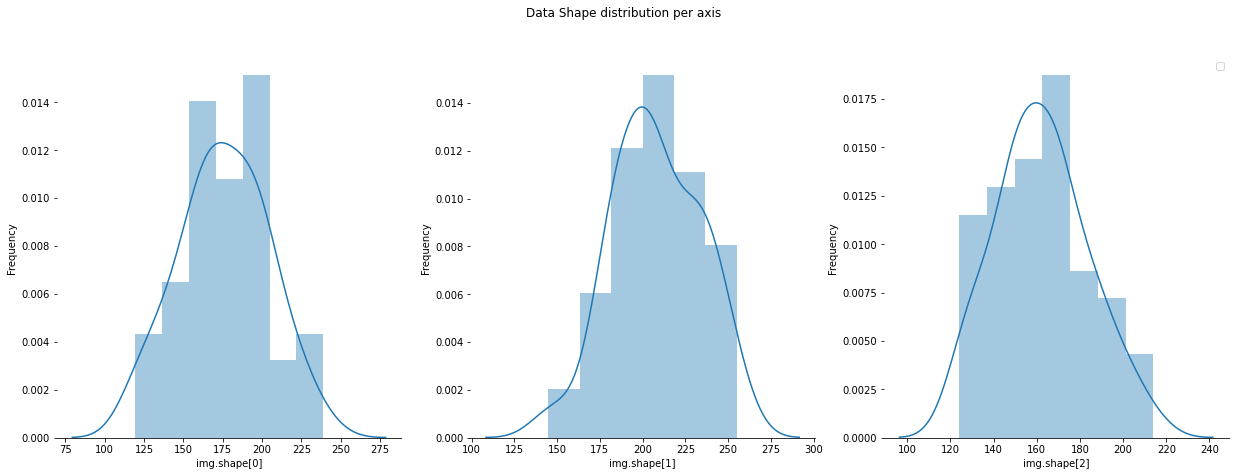

<Figure size 432x288 with 0 Axes>

In [ ]:
# xplot_train_val_les_dist()
# preprocess_for_batgen()
# normalize_from_resampled()
# get_global_data_stats()
plot_data_shape_distribution()
# lesion_summary()
# plot_lesion_int_distribution()

In [ ]:
from nilearn.image import resample_img

In [ ]:
def preprocess_reshape():
  '''
  1. Load nii img and mask using nibabel
  2. Resample img(continuous) and mask(nearest) to 1x1x1mm using nilearn.resample_img
  3. Rotate and flip for better view
  4. min-max or z normalization for img
  5. Extract liver from img
  6. For mask, make liver as background and clip mask values to (0,1)
  7. Remove the blank voxels
  8. Save as img and mask as .npy files
  '''
  os.chdir(raw_data_path)
  img_names = glob("*pre*")
  os.chdir(raw_seg_path)
  mask_names = glob("*pre*")
  os.chdir(project_path)
  img_names.sort()
  mask_names.sort()
  print(len(img_names), len(mask_names), img_names[0], mask_names[0])
  for ind in range(len(img_names)):
    ind = 6
    print(ind, img_names[ind], mask_names[ind])
    img = nibabel.load(raw_data_path + img_names[ind])
    mask = nibabel.load(raw_seg_path + mask_names[ind])

    print(img.affine, mask.affine)
    # img = resample_img(img, np.eye(4))
    # mask = resample_img(mask, np.eye(4))

    img = img.get_fdata()
    mask = mask.get_fdata()
    
    img = np.rot90(img)
    mask = np.rot90(mask)
    
    img = np.fliplr(img)   #only for thesis
    mask = np.fliplr(mask)

    img *= np.clip(mask, 0, 1)
    
    mask = np.clip(mask, 0, 2)
    mask[mask == 1] = 0
    mask[mask == 2] = 1

    img, mask = trim_data(img, mask)

    img = np.squeeze(img)
    mask = np.squeeze(mask)

    # img = nibabel.Nifti1Image(img, affine=np.eye(4))
    # mask = nibabel.Nifti1Image(mask, affine=np.eye(4))

    # img = resample_img(img, target_affine=np.eye(4), target_shape=(224, 224, 90))
    # mask = resample_img(mask, target_affine=np.eye(4), target_shape=(224, 224, 90))

    # print(img.affine, mask.affine)

    # img = img.get_fdata()
    # mask = mask.get_fdata()

    mask = mask.astype('uint8')
    img = img.astype('float32')

    return img, mask
    break

In [ ]:
img, mask = preprocess_reshape()

54 54 d001_pre0_dat.nii.gz d001_pre0_seg.nii.gz
6 d010_pre0_dat.nii.gz d010_pre0_seg.nii.gz
[[   1.            0.            0.         -158.19439697]
 [   0.            1.            0.         -145.34413147]
 [   0.            0.            2.5         -66.93356323]
 [   0.            0.            0.            1.        ]] [[   1.            0.            0.         -158.19439697]
 [   0.            1.            0.         -145.34413147]
 [   0.            0.            2.5         -66.93356323]
 [   0.            0.            0.            1.        ]]
(325, 325, 96) (325, 325, 96)
(1, 1, 162, 190, 80) (1, 1, 162, 190, 80)


In [ ]:
print(img.shape, mask.shape)

(162, 190, 80) (162, 190, 80)


In [ ]:
for ind in range(img.shape[-1]):
  print(ind)
  show_imgs([img[...,ind], mask[...,ind]])

In [ ]:
ind = 1
imgs = np.load(data_path + img_names[ind])
masks = np.load(seg_path + mask_names[ind])
stat(imgs)
print(imgs.shape, masks.shape)
stat(imgs)
for ind in range(0,imgs.shape[-1]):
  # show_imgs([imgs[:,:,ind], masks[:,:,ind]])
  show_imgs([imgs[0,0,:,:,ind], masks[0,0,:,:,ind]])
  # show_imgs([imgs[0,0,ind,:,:], masks[0,0,ind,:,:]])

###**Model**

In [ ]:
tr_gen, val_gen = get_train_val_generators()

44 ['d001_pre0_dat.npy', 'd002_pre0_dat.npy', 'd003_pre0_dat.npy', 'd004_pre0_dat.npy', 'd005_pre0_dat.npy', 'd006_pre0_dat.npy', 'd010_pre0_dat.npy', 'd012_pre0_dat.npy', 'd014_pre0_dat.npy', 'd017_pre0_dat.npy', 'd018_pre0_dat.npy', 'd019_pre0_dat.npy', 'd020_pre0_dat.npy', 'd021_pre0_dat.npy', 'd022_pre0_dat.npy', 'd030_pre0_dat.npy', 'd031_pre0_dat.npy', 'd032_pre0_dat.npy', 'd034_pre0_dat.npy', 'd035_pre0_dat.npy', 'd036_pre0_dat.npy', 'd037_pre0_dat.npy', 'd040_pre0_dat.npy', 'd042_pre0_dat.npy', 'd043_pre0_dat.npy', 'd045_pre0_dat.npy', 'd047_pre0_dat.npy', 'd048_pre0_dat.npy', 'd050_pre0_dat.npy', 'd053_pre0_dat.npy', 'd054_pre0_dat.npy', 'd056_pre0_dat.npy', 'd057_pre0_dat.npy', 'd058_pre0_dat.npy', 'd059_pre0_dat.npy', 'd060_pre0_dat.npy', 'd061_pre0_dat.npy', 'd062_pre0_dat.npy', 'd063_pre0_dat.npy', 'd064_pre0_dat.npy', 'd065_pre0_dat.npy', 'd066_pre0_dat.npy', 'd067_pre0_dat.npy', 'd068_pre0_dat.npy']
10 ['d070_pre0_dat.npy', 'd071_pre0_dat.npy', 'd072_pre0_dat.npy', 'd073

In [ ]:
check_queue(tr_gen, val_gen)

[0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 1, 1]


In [ ]:
train_generator = generator3D_patch(tr_gen)
val_generator = generator3D_patch(val_gen)

In [ ]:
# Check patch distribution. (with and without lesions)
avg_1 = 0
for ind in range(40):
  imgs, masks = next(train_generator)
  _uval, _uval_ct = np.unique(masks, return_counts=True)
  print(ind, _uval, _uval_ct, masks)
  avg_1 += np.count_nonzero(masks)/batch_size
print(avg_1/40)

In [ ]:
#View 3D patches
imgs, masks = next(train_generator)
stat(imgs)
stat(masks)
print(imgs.shape, masks.shape)
# for ind in range(imgs.shape[-2]):
#   print(ind)
#   # show_imgs([imgs[0,ind,:,:,0], masks[0,ind,:,:,0]])
#   show_imgs([imgs[0,:,:,ind,0], masks[0,:,:,ind,0]])

min :  -3.4892334938049316  max :  6.051799297332764  median :  -0.19495875388383865  avg :  6.432774829652488e-08  std :  0.9999999316087054
min :  0.0  max :  1.0  median :  0.5  avg :  0.5  std :  0.5
(8, 64, 64, 64, 1) (8,)


In [ ]:
train_generator = generator2D_patch(tr_gen)
val_generator = generator2D_patch(val_gen)

In [ ]:
#View 2D patches
imgs, masks = next(train_generator)
stat(imgs)
stat(masks)
print(imgs.shape, masks.shape)
# for ind in range(imgs.shape[0]):
#   if(len(np.unique(masks[ind])) == 1):
#     continue
#   print(ind)
#   show_imgs([imgs[ind], masks[ind]])

In [ ]:
def conv_bn_relu_drop(x, nf, ker_size, stride_size, d_rate):
  x = Conv3D(filters = nf, kernel_size = ker_size, padding='same', strides=stride_size)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  # x = SpatialDropout3D(d_rate)(x)
  return x

def transconv_bn_relu_drop(x, nf, ker_size, str_size, d_rate):
  x = Conv3DTranspose(filters = nf, kernel_size = ker_size, padding='same', strides=str_size)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  # x = SpatialDropout3D(d_rate)(x)
  return x

def fc_bn_relu_drop(x, nodes, d_rate):
  x = Dense(units = nodes)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  # x = Dropout(d_rate)(x)
  return x

In [ ]:
def VNet():
    inputs = Input((patch_size[0], patch_size[1], patch_size[2], 1))
    x = inputs
    nf = 16
    depth = model_depth
    d_rate = dropout_rate
    skips = []

    for i in range(depth):
        res = x
        for _ in range(min(i+1, depth-1)):
          x = conv_bn_relu_drop(x, nf, 5, 1, d_rate)
        # x += conv_bn_relu_drop(res, nf, 1, 1, d_rate)
        x += Conv3D(nf, 1, 1, activation='relu')(res)
        skips.append(x)
        x = conv_bn_relu_drop(x, nf, (2,2,2), 2, d_rate)
        nf = nf * 2

    res = x
    for i in range(2):
      x = conv_bn_relu_drop(x, nf, 5, 1, d_rate)
    x += conv_bn_relu_drop(res, nf, 1, 1, d_rate)
    nf = nf * 2

    for i in reversed(range(depth)):
        nf = nf // 2
        x = transconv_bn_relu_drop(x, nf, (2,2,2), 2, d_rate)
        res = x
        x = concatenate([skips[i], x])
        for _ in range(min(i+1, depth-1)):
          x = conv_bn_relu_drop(x, nf, 5, 1, d_rate)
        # x += conv_bn_relu_drop(res, nf, 1, 1, d_rate)
        x += Conv3D(nf, 1, 1, activation='relu')(res)

    conv6 = Conv3D(1,1)(x)
    conv7 = Activation('sigmoid')(conv6)
    model = Model(inputs=inputs, outputs=conv7)

    return model

In [ ]:
def Det_VNet():
    inputs = Input((patch_size[0], patch_size[1], patch_size[2], 1))
    x = inputs
    nf = nfilters
    depth = model_depth
    d_rate = dropout_rate
    skips = []

    for i in range(depth):
        res = x
        for _ in range(min(i+1, depth-1)):
          x = conv_bn_relu_drop(x, nf, 5, 1, d_rate)
        x += conv_bn_relu_drop(res, nf, 1, 1, d_rate)
        skips.append(x)
        x = conv_bn_relu_drop(x, nf, 2, 2, d_rate)
        nf = nf * 2

    res = x
    for i in range(3):
      x = conv_bn_relu_drop(x, nf, 5, 1, d_rate)
    x += conv_bn_relu_drop(res, nf, 1, 1, d_rate)
    nf = nf * 2

    # x = AveragePooling3D(4)(x)
    x = Flatten()(x)

    # Fully Connected Layers
    # x = fc_bn_relu_drop(x, 8192, d_rate)
    x = fc_bn_relu_drop(x, 4096, d_rate)
    # x = fc_bn_relu_drop(x, 2048, d_rate)
    x = fc_bn_relu_drop(x, 512, d_rate)
    # x = fc_bn_relu_drop(x, 128, d_rate)
    x = fc_bn_relu_drop(x, 64, d_rate)
    # x = fc_bn_relu_drop(x, 16, d_rate)

    x = Dense(1)(x)
    out = Activation('sigmoid', dtype = 'float32')(x)
    model = Model(inputs = inputs, outputs = out)
    return model

In [ ]:
model = Det_VNet()

In [ ]:
model.summary(line_length=150)

Model: "model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_2 (InputLayer)                             [(None, 64, 64, 64, 1)]          0                                                                   
______________________________________________________________________________________________________________________________________________________
conv3d (Conv3D)                                  (None, 64, 64, 64, 16)           2016              input_2[0][0]                                     
______________________________________________________________________________________________________________________________________________________
conv3d_1 (Conv3D)                                (None, 64, 64, 64, 16)        

In [ ]:
# Clear any logs from previous runs
# !rm -rf ./logs/ 

In [ ]:
model_id = 'SavedModels/' + time.strftime("%m-%d") + '_Det_' + dataset_name[:-1] + '_' + dim_type + '_' + str(batch_size) +'_' +  str(patch_size[0]) +'x' + str(patch_size[-1]) + '_' + str(nfilters) + '_' + str(model_depth) + '_' + str(dropout_rate) + '_' +  str(epochs) +'_' + opt 

In [ ]:
# model_id = 'SavedModels/06-06_xxx_Thesis_3D_8_64x64_16_4_0.0_500_Adam'

In [ ]:
model_id

'SavedModels/06-10_Det_Thesis_3D_8_64x64_16_4_0.0_500_Adam'

In [ ]:
import tensorflow_addons as tfa

In [ ]:
model.compile(optimizer=Adam(), loss = tf.keras.losses.binary_crossentropy, metrics=[f1_score, 'accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

cb_checkpoint = ModelCheckpoint(model_id + '_cp.h5', monitor='val_dice_coef', save_best_only=False)
cb_terminateonNaN = TerminateOnNaN()
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# cb_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
cb_csv = CSVLogger(model_id + '_CSV.csv', separator=',', append=False)

history = model.fit(
        train_generator,
        steps_per_epoch=train_steps_per_epoch,
        epochs = 100,
        validation_data=val_generator,
        validation_steps=val_steps_per_epoch,
        callbacks=[cb_terminateonNaN, cb_csv])

model.save(model_id + '_m.h5')
with open(model_id + '_History', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/100
40/40 [==============================] - 15s 364ms/step - loss: 0.6083 - f1_score: 0.6738 - accuracy: 0.6812 - precision: 0.6467 - recall: 0.7628 - val_loss: 8343.2197 - val_f1_score: 0.0000e+00 - val_accuracy: 0.5500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
40/40 [==============================] - 45s 1s/step - loss: 0.4773 - f1_score: 0.8215 - accuracy: 0.8094 - precision: 0.7527 - recall: 0.9032 - val_loss: 108.1290 - val_f1_score: 0.0000e+00 - val_accuracy: 0.5500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
40/40 [==============================] - 56s 1s/step - loss: 0.4937 - f1_score: 0.8104 - accuracy: 0.8000 - precision: 0.7500 - recall: 0.8846 - val_loss: 3.4374 - val_f1_score: 0.5844 - val_accuracy: 0.6750 - val_precision: 0.6333 - val_recall: 0.5588
Epoch 4/100
40/40 [==============================] - 59s 1s/step - loss: 0.4949 - f1_score: 0.7734 - accuracy: 0.7594 - precision: 0.7053 - recall: 0.8645 - val_loss: 2.8851

In [ ]:
# model = UNet3D()
# model = load_model(model_id + '_cp.h5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef' : dice_coef, 'precision' : precision, 'recall' : recall})
# model_id = model_id + '_2'
model.compile(optimizer = Adam(), loss=dice_coef_loss, metrics=[dice_coef, precision, recall])

cb_checkpoint = ModelCheckpoint(model_id + '_cp.h5', monitor='val_dice_coef', save_best_only=False)
cb_terminateonNaN = TerminateOnNaN()
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# cb_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
cb_csv = CSVLogger(model_id + '_CSV.csv', separator=',', append=False)

history = model.fit(
        train_generator,
        steps_per_epoch=train_steps_per_epoch,
        epochs = 10,
        validation_data=val_generator,
        validation_steps=val_steps_per_epoch,
        callbacks=[cb_csv, cb_terminateonNaN])

model.save(model_id + '_m.h5')
with open(model_id + '_History', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
model_id += '_2'

In [ ]:
print(model_id)

SavedModels/06-08_Det_Thesis_3D_8_64x64_16_4_0.0_500_Adam


In [ ]:
# model.save(model_id + '_m.h5')

In [ ]:
hist = pickle.load(open(model_id + '_History', "rb"))

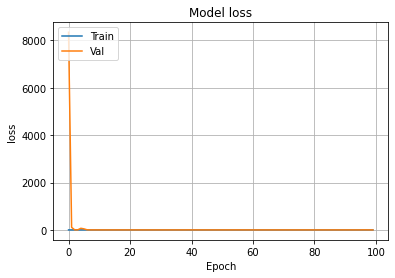

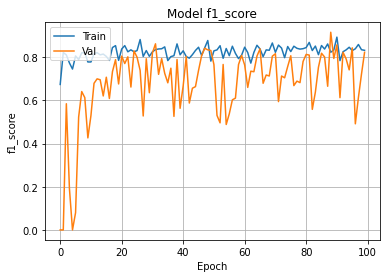

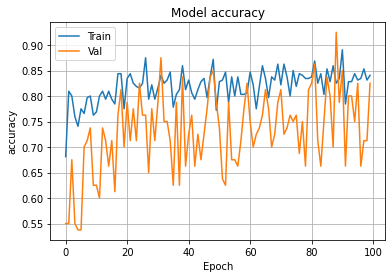

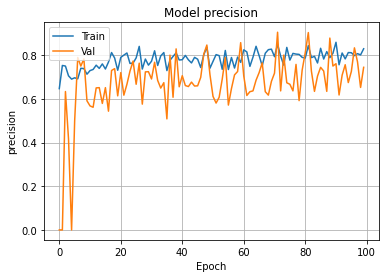

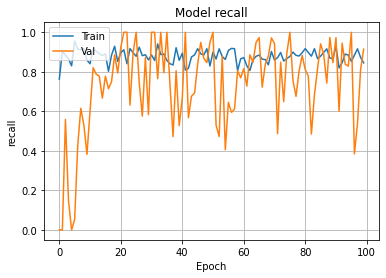

In [ ]:
plot_history(hist)

### **Inference**

In [ ]:
#For Detection
model = load_model(model_id + '_m.h5', custom_objects={'f1_score' : f1_score})
# model = load_model(model_id + '_cp.h5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef' : dice_coef, 'precision' : precision, 'recall' : recall})

OSError: ignored

In [ ]:
model = load_model(model_id + '_m.h5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef' : dice_coef, 'precision' : precision, 'recall' : recall})
# model = load_model(model_id + '_cp.h5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef' : dice_coef, 'precision' : precision, 'recall' : recall})

In [ ]:
pi#Inference on training batch
imgs, masks = next(train_generator)
preds = model.predict(imgs)
print(preds)
# tf.print(dice_coef(masks, preds), precision(masks, preds), recall(masks, preds))
tf.print(f1_score(masks, preds), tf.keras.metrics.Precision()(masks, preds), tf.keras.metrics.Recall()(masks, preds))

KeyboardInterrupt: ignored

In [ ]:
for ind in range(40):
  imgs, masks = next(train_generator)
  preds = model.predict(imgs)
  print(ind, masks.reshape(-1,), preds.reshape(-1,))

In [ ]:
# np.unique(preds, return_counts=True)

In [ ]:
#3D Batch
for ind in range(preds.shape[0]):
  imgs_train_predicto = get_overlay(np.squeeze(imgs[ind]), np.squeeze(masks[ind]), np.squeeze(preds[ind]))

In [ ]:
#Inference on each patient record
for ind in range(len(img_names)):
  # ind = 4
  imgs = np.load(data_path + img_names[ind])
  masks = np.load(seg_path + mask_names[ind])
  imgs = np.squeeze(imgs)
  masks = np.squeeze(masks)
  if (ind in train_ind):
    label = 'train'
  elif(ind in val_ind):
    label = 'val'
  else:
    continue
  imgs = imgs.astype('float32')
  masks = masks.astype('float32')
  imgs, masks = get_block_padded(imgs, masks)
  preds = get_block_preds(imgs, masks)
  tf.print(ind, label, img_names[ind], dice_coef(masks, preds), precision(masks, preds), recall(masks, preds))
  # break

In [ ]:
imgs.shape, masks.shape, preds.shape

In [ ]:
# Single 3D record
get_overlay(imgs, masks, preds)

In [ ]:
def get_block_padded(img_ex, mask_ex):
  patch_size = [32, 32, 32]  #When using strides, give stride_size as patch_size
  pad_value = [int((patch_size[i] - img_ex.shape[i])%patch_size[i]) for i in range(len(patch_size))]
  img_ex = np.pad(img_ex, ((pad_value[0]//2, pad_value[0] - pad_value[0]//2), (pad_value[1]//2, pad_value[1] - pad_value[1]//2), (pad_value[2]//2, pad_value[2] - pad_value[2]//2)), mode='constant')
  mask_ex = np.pad(mask_ex, ((pad_value[0]//2, pad_value[0] - pad_value[0]//2), (pad_value[1]//2, pad_value[1] - pad_value[1]//2), (pad_value[2]//2, pad_value[2] - pad_value[2]//2)), mode='constant')
  return img_ex, mask_ex

In [ ]:
#Get dice score of the block
def get_block_preds(img_ex, mask_ex):
  '''
  Get Predictions
  '''
  stride = [32, 32, 32]
  block_pflags = np.zeros(img_ex.shape, dtype = 'float32')
  block_preds = np.zeros(img_ex.shape, dtype='float32')

  for x in range(patch_size[0], img_ex.shape[0]+1, stride[0]):
    for y in range(patch_size[1], img_ex.shape[1]+1, stride[1]):
      for z in range(patch_size[2], img_ex.shape[2]+1, stride[2]):
        img_ex_one = img_ex[x-patch_size[0]:x, y-patch_size[1]:y, z-patch_size[2]:z]
        mask_ex_one = mask_ex[x-patch_size[0]:x, y-patch_size[1]:y, z-patch_size[2]:z]
        img_ex_one = img_ex_one[np.newaxis,...,np.newaxis]
        mask_ex_one = mask_ex_one[np.newaxis,...,np.newaxis]
        pred_ex_one = model.predict(img_ex_one)
        pred_ex_one = np.round(pred_ex_one)
        block_pflags[x-patch_size[0]:x, y-patch_size[1]:y, z-patch_size[2]:z] += 1.0
        block_preds[x-patch_size[0]:x, y-patch_size[1]:y, z-patch_size[2]:z] += np.squeeze(pred_ex_one)
  block_preds = np.round(block_preds/block_pflags)
  return block_preds

###**Inference for Detection**

In [ ]:
#Inference on each patient record
for ind in range(len(img_names)):
  ind = 6
  imgs = np.load(data_path + img_names[ind])
  masks = np.load(seg_path + mask_names[ind])
  imgs = imgs.astype('float32')
  masks = masks.astype('float32')
  imgs = np.squeeze(imgs)
  masks = np.squeeze(masks)
  if (ind in train_ind):
    label = 'train'
  elif(ind in val_ind):
    label = 'val'
  else:
    continue
  # print(imgs.shape, masks.shape)
  imgs, masks = get_block_padded(imgs, masks)
  masks, preds = get_block_preds_d(imgs, masks)
  # print(masks.shape, preds.shape)
  tf.print(ind, label, img_names[ind], f1_score(masks, preds), tf.keras.metrics.Precision()(masks, preds), tf.keras.metrics.Recall()(masks, preds))
  break

0 0.0 0.0013077578
1 0.0 0.0029433176
2 0.0 0.010690071
3 1.0 0.01646372
4 1.0 0.010417654
5 1.0 0.001564566
6 0.0 0.00574386
7 0.0 0.09622884
8 1.0 0.095761545
9 1.0 0.13928992
10 1.0 0.10561378
11 1.0 0.13206302
12 0.0 0.0032710512
13 0.0 0.033737276
14 1.0 0.10973405
15 1.0 0.3918548
16 1.0 0.3154365
17 1.0 0.12572016
18 0.0 0.004978489
19 0.0 0.036316957
20 1.0 0.08484173


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


21 1.0 0.5409873
22 1.0 0.11307952
23 1.0 0.024585182
24 0.0 0.004978489
25 0.0 0.02111297
26 0.0 0.068988115
27 1.0 0.11434254
28 1.0 0.19602974
29 1.0 0.0057218526
30 0.0 0.0835233
31 1.0 0.08886586
32 1.0 0.18539429
33 1.0 0.24130549
34 1.0 0.16311133
35 1.0 0.117996275
36 0.0 0.15328115
37 1.0 0.3481521
38 1.0 0.84940517
39 1.0 0.85191417
40 1.0 0.47913843
41 1.0 0.602509
42 0.0 0.0036931424
43 1.0 0.016101273
44 1.0 0.07978591
45 1.0 0.93009645
46 1.0 0.9641165
47 1.0 0.3536345
48 0.0 0.004978489
49 0.0 0.007099053
50 1.0 0.37677923
51 1.0 0.38735119
52 1.0 0.95523673
53 1.0 0.18207349
54 0.0 0.004978489
55 0.0 0.005326998
56 0.0 0.040450554
57 1.0 0.269426
58 1.0 0.22595899
59 1.0 0.07324092
60 0.0 0.46963862
61 1.0 0.24839547
62 1.0 0.84331
63 1.0 0.7650712
64 1.0 0.6166093
65 1.0 0.11218753
66 0.0 0.41948727
67 1.0 0.41687056
68 1.0 0.86668503
69 1.0 0.78929824
70 1.0 0.8930676
71 1.0 0.8816182
72 0.0 0.0033151235
73 1.0 0.004916794
74 1.0 0.07073583
75 1.0 0.3915179
76 1.0 0.9

In [ ]:
#Get dice score of the block
def get_block_preds_d(img_ex, mask_ex):
  '''
  Get Predictions
  '''
  stride = [32, 32, 32]
  # patch_size = patch_size
  masks = []
  preds = []
  ind = 0
  for x in range(patch_size[0], img_ex.shape[0]+1, stride[0]):
    for y in range(patch_size[1], img_ex.shape[1]+1, stride[1]):
      for z in range(patch_size[2], img_ex.shape[2]+1, stride[2]):
        img_ex_one = img_ex[x-patch_size[0]:x, y-patch_size[1]:y, z-patch_size[2]:z]
        _mean = np.mean(img_ex_one)
        _std = np.std(img_ex_one)
        img_ex_one = (img_ex_one - _mean)/_std
        # img_ex_one = zero_mean_unit_variance_normalization(img_ex_one, per_channel = False)
        mask_ex_one = mask_ex[x-patch_size[0]:x, y-patch_size[1]:y, z-patch_size[2]:z]
        img_ex_one = img_ex_one[np.newaxis,...,np.newaxis]
        mask_ex_one = mask_ex_one[np.newaxis,...,np.newaxis]
        pred_ex_one = model.predict(img_ex_one)
        # pred_ex_one = np.round(pred_ex_one)
        preds.append(np.squeeze(pred_ex_one))
        masks.append(np.max(mask_ex_one))
        # print(ind, x-patch_size[0], y-patch_size[1], z-patch_size[2], masks[-1], preds[-1])
        print(ind, masks[-1], preds[-1])
        ind += 1
  masks = np.array(masks)
  preds = np.array(preds)
  preds = preds.astype('float32')
  masks = masks.astype('float32')
  # print(masks.shape, preds.shape)
  return masks, preds

In [ ]:
imgs.shape, masks.shape, preds.shape

In [ ]:
np.argmin(abs(masks - preds))

In [ ]:
x = abs(masks - preds)
x.sort()

In [ ]:
y = np.argsort(abs(masks - preds))

In [ ]:
imgs = np.load(data_path + img_names[ind])
imgs = imgs.astype('float32')
masks = np.load(seg_path + mask_names[ind])
masks = masks.astype('float32')
imgs = np.squeeze(imgs)
masks = np.squeeze(masks)

In [ ]:
img = imgs[32:32+64,32:32+64,128:128+64]

In [ ]:
img.shape

In [ ]:
for i in range(img.shape[-1]):
  print(i, np.unique(img[:,:,i], return_counts=True))
  show_imgs([img[:,:,i]])

In [ ]:
img.shape

In [ ]:
# Single 3D record
get_overlay(imgs, masks, preds)